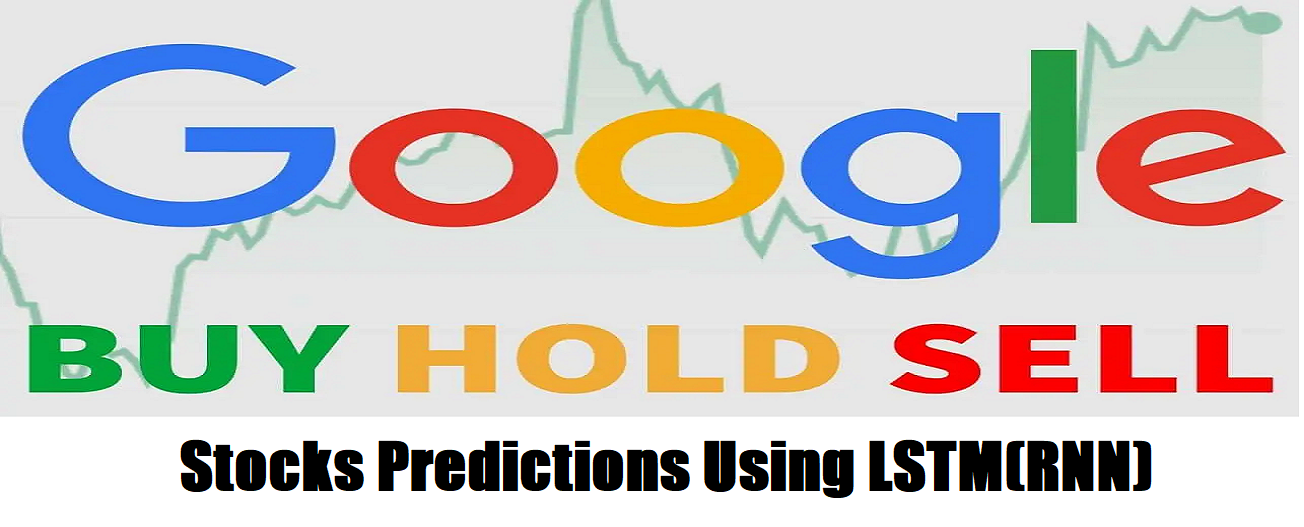

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### Loading Google stocks Data from Yahoo Finanace

In [ ]:
start = pd.to_datetime(['2005-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2023-02-18']).astype(int)[0]//10**9 # convert to unix timestamp.
stock_ticker="GOOG"
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,4.916571,5.071989,4.868253,5.048826,5.048826,636143518
1,2005-01-04,5.016198,5.054305,4.818937,4.844342,4.844342,552298420
2,2005-01-05,4.818190,4.904118,4.787804,4.819685,4.819685,330698912
3,2005-01-06,4.858788,4.879212,4.675475,4.696148,4.696148,417041336
4,2005-01-07,4.748203,4.838116,4.701876,4.828153,4.828153,387964757


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4559,2023-02-13,95.010002,95.349998,94.050003,95.000000,95.000000,43116600
4560,2023-02-14,94.660004,95.175003,92.650002,94.949997,94.949997,42513100
4561,2023-02-15,94.739998,97.339996,94.360001,97.099998,97.099998,37029900
4562,2023-02-16,95.540001,97.879997,94.970001,95.779999,95.779999,35642100
4563,2023-02-17,95.070000,95.750000,93.449997,94.589996,94.589996,31074100


In [ ]:
df.shape

(4564, 7)

In [ ]:
df.size

31948

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4564 entries, 0 to 4563
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4564 non-null   object 
 1   Open       4564 non-null   float64
 2   High       4564 non-null   float64
 3   Low        4564 non-null   float64
 4   Close      4564 non-null   float64
 5   Adj Close  4564 non-null   float64
 6   Volume     4564 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 249.7+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4564.000000,4564.000000,4564.000000,4564.000000,4564.000000,4.564000e+03
mean,38.738050,39.140311,38.339305,38.746336,38.746336,1.180022e+08
std,35.456987,35.856115,35.077051,35.469144,35.469144,1.464472e+08
min,4.366135,4.443345,4.298140,4.358414,4.358414,1.584340e+05
25%,12.932775,13.050832,12.798279,12.926112,12.926112,2.942793e+07
50%,26.156250,26.382585,25.870722,26.169327,26.169327,6.494900e+07
75%,54.725001,55.332375,54.214450,54.759373,54.759373,1.460875e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


In [ ]:
df.describe(include='O')

,Date
count,4564
unique,4564
top,2005-01-03
freq,1


### Select Date and Close columns for further time series analysis

In [ ]:
data=df[['Date','Close']]
data.head()

,Date,Close
0,2005-01-03,5.048826
1,2005-01-04,4.844342
2,2005-01-05,4.819685
3,2005-01-06,4.696148
4,2005-01-07,4.828153


In [ ]:
data['Date']=pd.to_datetime(data['Date'])

### Plot the Google Stocks

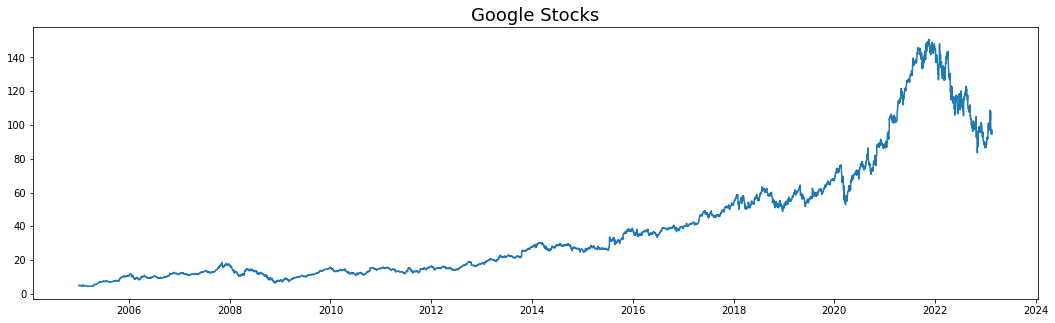

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(data.set_index("Date"))
plt.title("Google Stocks", fontsize=18);

### Create array of Column Close

In [ ]:
close=data['Close'].values.reshape(-1,1)
close

array([[ 5.048826],
       [ 4.844342],
       [ 4.819685],
       ...,
       [97.099998],
       [95.779999],
       [94.589996]])

In [ ]:
close.shape

(4564, 1)

### Standardize using MinMax Scaler

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))

scaled_data=scaler.fit_transform(close)
scaled_data

array([[0.00471752],
       [0.0033203 ],
       [0.00315182],
       ...,
       [0.63369465],
       [0.62467522],
       [0.61654404]])

### Train Test Split

In [ ]:
# I am taking 90% data to train the model
train_index=math.ceil(len(close)*0.9)
train_index

4108

In [ ]:
train_data=scaled_data[:train_index, :]
test_data=scaled_data[train_index:, :]
print("Train shape", train_data.shape)
print("Test shape", test_data.shape)

Train shape (4108, 1)
Test shape (456, 1)


### Filter the Train data

In [ ]:
X_train=[]
y_train=[]
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train =np.array(X_train), np.array(y_train)
print("x Train shape", x_train.shape)
print("y Train shape", y_train.shape)

x Train shape (4048, 60)
y Train shape (4048,)


In [ ]:
# Here we are reshaping the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4048, 60, 1)

### Filter the Test data

In [ ]:
test_data = scaled_data[train_index - 60: , : ]
x_test = []
y_test =  close[train_index : , :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

print("Test Data Shape", test_data.shape)
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
print("x_test shape", x_test.shape)

Test Data Shape (516, 1)
x_test shape (456, 60, 1)


### Create RNN/LSTM model

In [ ]:
# Input layer
model=Sequential()

model.add(LSTM(units=50,return_sequences=True, activation="linear", input_shape=(60,1)))

In [ ]:
# Hidden layer
model.add(LSTM(units=50,return_sequences=True ,activation="linear",))
model.add(LSTM(units=100,return_sequences=False, activation="linear", ))
model.add(Dense(units=10, activation="linear",))

In [ ]:
# Output layer
model.add(Dense(units=1, activation="linear"))


In [ ]:
# Optimizer
import keras
opt = keras.optimizers.RMSprop(learning_rate=0.001)

# Compile Layer
model.compile(optimizer=opt, loss="mean_squared_error")

In [ ]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 92,021
Trainable params: 92,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit and train the model
model.fit(x_train, y_train, batch_size=20, epochs=15)

Epoch 1/15
203/203 [==============================] - 25s 103ms/step - loss: 0.0022
Epoch 2/15
203/203 [==============================] - 23s 113ms/step - loss: 6.5342e-04
Epoch 3/15
203/203 [==============================] - 20s 97ms/step - loss: 4.7375e-04
Epoch 4/15
203/203 [==============================] - 21s 103ms/step - loss: 3.8681e-04
Epoch 5/15
203/203 [==============================] - 20s 99ms/step - loss: 3.1421e-04
Epoch 6/15
203/203 [==============================] - 22s 107ms/step - loss: 2.5946e-04
Epoch 7/15
203/203 [==============================] - 23s 112ms/step - loss: 2.4977e-04
Epoch 8/15
203/203 [==============================] - 20s 97ms/step - loss: 2.1904e-04
Epoch 9/15
203/203 [==============================] - 31s 152ms/step - loss: 1.9135e-04
Epoch 10/15
203/203 [==============================] - 19s 96ms/step - loss: 1.8358e-04
Epoch 11/15
203/203 [==============================] - 21s 101ms/step - loss: 1.6835e-04
Epoch 12/15
203/203 [=================

### Prediction

In [ ]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)  # back to its original form
pred=pd.DataFrame(predictions, columns=["Predicted_value"])
pred.head()

15/15 [==============================] - 1s 70ms/step


,Predicted_value
0,119.980156
1,123.262688
2,122.564545
3,121.011887
4,118.955200


In [ ]:
pred.tail()

,Predicted_value
451,95.448532
452,96.624390
453,97.128517
454,98.849678
455,98.141930


In [ ]:
actual=pd.DataFrame(y_test, columns=['Actual_value'])
actual.head()

,Actual_value
0,121.494499
1,120.505997
2,119.758499
3,117.712502
4,117.836998


In [ ]:
actual.tail()

,Actual_value
451,95.000000
452,94.949997
453,97.099998
454,95.779999
455,94.589996


In [ ]:
res=pd.concat([actual, pred],axis=1)
res.head()

,Actual_value,Predicted_value
0,121.494499,119.980156
1,120.505997,123.262688
2,119.758499,122.564545
3,117.712502,121.011887
4,117.836998,118.955200


In [ ]:
res.tail()

,Actual_value,Predicted_value
451,95.000000,95.448532
452,94.949997,96.624390
453,97.099998,97.128517
454,95.779999,98.849678
455,94.589996,98.141930


### Evaluate the model

In [ ]:
from sklearn.metrics import mean_squared_error as mse

mse(res['Actual_value'], res['Predicted_value']).round(4)

11.0545

### Plot the Actual vs Predicted graph

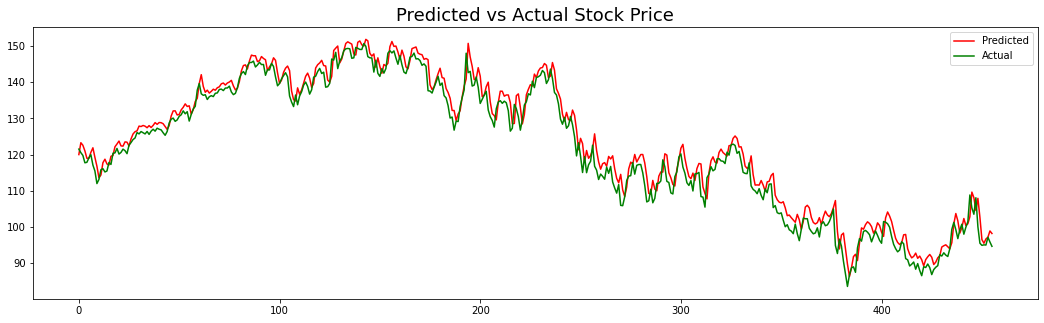

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(res["Predicted_value"], label="Predicted", color="red")
plt.plot(res["Actual_value"], label="Actual", color="green")
plt.legend()
plt.title("Predicted vs Actual Stock Price", fontsize=18)
plt.show();

**from above line plot Predicted and Actual values are almost similar, and the MSE is just 11, Hence this model is good.**